## Data

In [3]:
import pandas as pd
## pandas 1.1.1 necessary
import numpy as np
import string 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from gensim.models import Word2Vec
from plotly.graph_objects import Scatter3d
import matplotlib.pyplot as plt
import random

### Different Docs

In [144]:
merger = pd.read_pickle("../../raw_data/merger")
extract = merger[["index","content_y"]]

In [147]:
merger2 = pd.read_pickle("../../raw_data/merger2")
merger2["content_y"] = merger2["content"]
extract2 = merger2[["index","content_y"]]

In [265]:
merger3 = pd.read_pickle("../../raw_data/czech")
merger3 = merger3.reset_index()
merger3["content_y"] = merger3["content"]
extract3 = merger3[["index","content_y"]] 

In [288]:
merger4 = pd.read_pickle("../../raw_data/merger_spain")
merger4 = merger4.reset_index()
merger4["content_y"] = merger4["content"]
extract4 = merger4[["index","content_y"]] 

In [4]:
#Getting all the data
data = pd.read_pickle("../../delphes/data/update_age_sex")
data = data.reset_index()

In [336]:
extract2

index                                          content_y
0      20738  [False, False, [-0.0564866, 0.0520961, -0.0289...
1      20739  [False, [0.0680034, -0.0906367, -0.0319666, 0....
2      20740  [False, False, False, False, False, False, Fal...
3      20741  [[-0.0393396, 0.0268131, -0.142318, 0.0613933,...
4      20742  [[-0.0393396, 0.0268131, -0.142318, 0.0613933,...
...      ...                                                ...
7795  130490  [[0.0109718, -0.0593663, -0.0322032, 0.0416514...
7796  130491  [[0.0186351, -0.0140546, -0.0420493, -0.067852...
7797  130492  [[0.0489321, -0.0598671, -0.0264063, -0.014537...
7798  130493  [[-0.133483, 0.0550787, -0.0270976, 0.00313864...
7799  130494  [[0.00139549, -0.0896719, -0.0270524, 0.020236...

[7800 rows x 2 columns]

## Cleaning

In [250]:
def drop_none(df):
    count = 0
    dropables = []
    for i in df["content_y"]:
        if i == None:
            dropables.append(count)
            count+= 1
        else:
            count+=1
    result = df.drop(labels=dropables)
    result = result.reset_index()
    return result

In [251]:
#Creating a dict_tweets with Index and Averaged Array
def dict_creation(df):
    tweets = []
    dict_tweets = {}
    for i in df["level_0"]:
        prov_results = []
        try :
            if len(df["content_y"][i]) > 1: 
                for j in range (0,len(df["content_y"][i])): 
                    if df["content_y"][i] != False: 
                        prov_results.append(df["content_y"][i][j])
                    else:
                        pass
            dict_tweets[df["index"][i]] = (sum(prov_results)/len(df["content_y"][i]))
        except KeyError:
            break
    return dict_tweets

In [252]:
def drop_floats(dict_tweets):
    floats = []
    for i,j in dict_tweets.items(): 
        if type(j) != np.ndarray:
            floats.append(i)
    for i in floats: 
        del dict_tweets[i]
        
    return dict_tweets

In [253]:
dict_tweets = drop_floats(dict_creation(drop_none(extract)))

In [254]:
dict_tweets2 = drop_floats(dict_creation(drop_none(extract2)))

In [266]:
dict_tweets3 = drop_floats(dict_creation(drop_none(extract3)))

In [289]:
dict_tweets4 = drop_floats(dict_creation(drop_none(extract4)))

### Merging Dicts

In [291]:
merged_dict = {}
for i,j in dict_tweets.items():
    merged_dict[i] = j
for i,j in dict_tweets2.items():
    merged_dict[i] = j
for i,j in dict_tweets3.items():
    merged_dict[i] = j
for i,j in dict_tweets4.items():
    merged_dict[i] = j

## Creating DF

In [292]:
df = pd.DataFrame(merged_dict).transpose()
df = df.reset_index()
tsv_df = df.drop(['index'], axis=1)

### Merging

In [308]:
all_info = data.merge(df,on="index")

## Label Ecoding

### Country

In [309]:
for i in all_info.country.unique():
    print (i)

Spain
Denmark
Netherlands
Portugal
Ireland
Czechia


In [311]:
def countries(values):
    count = 0
    for i in all_info.country.unique():
        if values == i:
            return count
        else:
            count += 1

In [312]:
all_info["countries"] = all_info["country"].apply(countries)

### European Group

In [313]:
def groups(values):
    if values == 'European Conservatives and Reformists Group':
        return 0
    elif values == 'Group of the European United Left - Nordic Green Left':
        return 1
    elif values == 'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament':
        return 2
    elif values == "Group of the European People's Party (Christian Democrats)":
        return 3
    elif values == 'Group of the Greens/European Free Alliance':
        return 4
    elif values == 'Non-attached Members':
        return 5
    elif values == 'Renew Europe Group':
        return 6

In [315]:
all_info["european_group"] = all_info["group"].apply(groups)

### National Party

parties_list = ['Socialistisk Folkeparti',
       'Volkspartij voor Vrijheid en Democratie',
       'Christen Democratisch Appèl', 'Partij van de Arbeid',
       'ChristenUnie', 'GroenLinks', 'Forum voor Democratie',
       'Socialdemokratiet', 'Partij voor de Dieren', 'Democraten 66',
       'Venstre, Danmarks Liberale Parti', 'Det Radikale Venstre',
       'GO Realisme & Daadkracht', 'Staatkundig Gereformeerde Partij',
       'Enhedslisten', 'Det Konservative Folkeparti']

def parties(values):
    for i in parties_list:
        if values == i:
            return parties_list.index(i)

all_info["nat_party_code"] = all_info["nat_group"].apply(parties)

### Age

In [318]:
def age_func(values):
    if values <= 30:
        return 0
    if (values > 30) & (values <= 40):
        return 1
    if (values > 40) & (values <=50):
        return 2
    if (values > 50) & (values <= 60):
        return 3
    if values > 60:
        return 4

In [319]:
all_info["age_code"] = all_info["age"].apply(age_func)

In [323]:
all_info.to_pickle("six_countries")

## Exporting Document

### Words Matrix

In [305]:
tsv_df.to_csv('df.tsv',sep="\t", index=False, header=False)

### Labels

In [321]:
all_info[["countries","european_group","sex","age_code"]].to_csv("multi_variables.tsv",sep="\t", index=False, header=True)

In [238]:
!pwd

/Users/simonpastor/code/simonjpastor/delphes/notebooks/simonjpastor_notebooks


### Pierre's Model

In [353]:
test = pd.concat([extract, extract2, extract3, extract4])

## Distance Analysis

### Converting DF to Dictionary

In [5]:
all_countries = pd.read_hdf('../../raw_data/full_mean_df_hdf.h5', 'h5')

In [6]:
all_countries = all_countries.reset_index()

In [7]:
list_extractor = []
list_extractor.append("index")
for i in (range(300)):
    list_extractor.append(i)

In [8]:
all_countries = all_countries[list_extractor]

In [9]:
dictionary = {}
for i in all_countries["index"]:
    temporary = []
    print(round(i/134724,1))
    for j in range(300):
        temporary.append(all_countries[j][i])
    dictionary[i] = np.array(temporary)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


KeyError: 134724

### Cosine Similarity

In [11]:
for i,j in dictionary.items():
    dictionary[i] = np.nan_to_num(j)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

distances = {}
def cosinux(x):
    for i in dictionary.keys():
        y = dictionary[i]
        result = cosine_similarity(x.reshape(-1, 1).transpose(), y.reshape(-1,1).transpose())
        distances[i] = result[0][0]
    return distances

In [13]:
def max_lists(x,top_x):
    distances = cosinux(x)
    maximum_list = []
    maximum_indexes = []
    for i, j in distances.items(): 
        if len(maximum_list) < top_x:
            maximum_list.append(j)
            maximum_indexes.append(i)
        else: 
            if j > min(maximum_list):
                maximum_list.append(j)
                del maximum_list[maximum_list.index(min(maximum_list))]
                maximum_indexes.append(i)
                del maximum_indexes[maximum_indexes.index(min(maximum_indexes))]
            else: 
                pass
    top100 = dict(zip(maximum_indexes,maximum_list))
    top100_df = pd.DataFrame([top100]).transpose().reset_index()
    return data.merge(top100_df,on="index")

### Stats

#### Country

In [14]:
def stats_country(x,top_x):
    df = max_lists(x,top_x)
    country_stats1=[]
    country_stats2=[]
    init = []
    sum = 0
    for i in df.groupby("country").count()[0].reset_index()["country"].values:
        country_stats1.append(i)
    for i in df.groupby("country").count().reset_index()[["country","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        country_stats2.append((i/sum)*100)    
    country = dict(zip(country_stats1,country_stats2))
    country_viz = pd.DataFrame([country]).transpose().reset_index()
    return country_viz

#### European Group

In [15]:
def group_encoding(values):
    if values == "United Left":
        return (103/255, 0, 0)
    elif values == "Socialists & Democrats":
        return (201/255, 0, 0)
    elif values == 'Greens':
        return (6/255, 137/255, 0)
    elif values == 'Renew Europe':
        return (251/255, 247/255, 45/255)
    elif values == "EPP":
        return (120/255, 119/255, 235/255)
    elif values == 'European Conservatives and Reformists':
        return (4/255, 112/255, 180/255)
    elif values == 'Identity & Democracy':
        return (0, 0, 169/255)
    elif values == 'Non-Attached':
        return (120/255, 119/255, 127/255)

In [16]:
def name_order(df):
    dict_test = {}
    list1 = []
    list2 = []
    order = {}
    for i in df["index"]:
        list1.append(i)
    for j in df[0]:
        list2.append(j)
    unordered = dict(zip(list1,list2))
    try:
        order["United Left"] = unordered['Group of the European United Left - Nordic Green Left']
    except KeyError: 
        pass
    try:    
        order['Socialists & Democrats'] = unordered['Group of the Progressive Alliance of Socialists and Democrats in the European Parliament']
    except KeyError: 
        pass
    try: 
        order['Greens'] = unordered['Group of the Greens/European Free Alliance']
    except KeyError: 
        pass
    try:
        order['Renew Europe'] = unordered['Renew Europe Group']
    except:
        pass
    try:
        order["EPP"] = unordered["Group of the European People's Party (Christian Democrats)"]
    except KeyError: 
        pass
    try:
        order["European Conservatives and Reformists"] = unordered['European Conservatives and Reformists Group']
    except KeyError: 
        pass
    try:
        order["Identity & Democracy"] = unordered["Identity and Democracy Group"]
    except KeyError: 
        pass
    try: 
        order['Non-Attached'] = unordered['Non-attached Members']
    except KeyError: 
        pass
    df = pd.DataFrame([order]).transpose().reset_index()
    return df

In [17]:
def stats_group(x,top_x):
    df = max_lists(x,top_x)
    country_stats1=[]
    country_stats2=[]
    init=[]
    sum = 0
    for i in df.groupby("group").count()[0].reset_index()["group"].values:
        country_stats1.append(i)
    for i in df.groupby("group").count().reset_index()[["group","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        country_stats2.append((i/sum)*100)
    group = dict(zip(country_stats1,country_stats2))
    group_viz = pd.DataFrame([group]).transpose().reset_index()
    group_viz = name_order(group_viz)
    group_viz["group_colors"] = group_viz["index"].apply(group_encoding)
    return group_viz

#### Sex

In [18]:
def stats_sex(x,top_x):
    df = max_lists(x,top_x)
    sex_stats1=[]
    sex_stats2=[]
    init=[]
    sum = 0
    for i in df.groupby("sex").count()[0].reset_index()["sex"].values:
        sex_stats1.append(i)
    for i in df.groupby("sex").count().reset_index()[["sex","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        sex_stats2.append((i/sum)*100)
    group = dict(zip(sex_stats1,sex_stats2))
    group["Men"] = group[0.0]
    group["Women"] = group[1.0]
    del group[0]
    del group[1]
    group_viz = pd.DataFrame([group]).transpose().reset_index()
    return group_viz

#### Age

In [19]:
def stats_age(x,top_x):
    df = max_lists(x,top_x)
    age_stats1=[]
    age_stats2=[]
    init=[]
    sum = 0
    for i in df.groupby("age").count()[0].reset_index()["age"].values:
        age_stats1.append(i)
    for i in df.groupby("age").count().reset_index()[["age","index"]]["index"].values:
        init.append(i)
        sum += i
    for i in init:
        age_stats2.append((i/sum)*100)
    group = dict(zip(age_stats1,age_stats2))
    group_viz = pd.DataFrame([group]).transpose().reset_index()
    return group_viz

### Plot the Output 

In [20]:
def color_generator(colors):
    color_list = {}
    color_output = []
    count = 0
    for i in range(0,colors):
        color_list[count] = ((random.random(), random.random(), random.random()))
        count += 1
    for i in color_list.values():
        color_output.append(i)
    return color_output

In [21]:
def group_color(x):
    color_order=[]
    for i in x["group_colors"]:
        color_order.append(i)
    return color_order

In [22]:
def stats(x,top_x):
    minutes = 0
    mins = top_x/10
    while mins > 0:
        mins = mins - 60
        minutes += 1 
    print(f'Estimated Wait Time : {minutes} mins')
    fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(30,20))
    #1st one
    variable = stats_country(x,top_x)
    colors = variable["index"].count()
    axs[0,0].bar(variable["index"],variable[0],color=color_generator(colors))
    axs[0,0].set_title("Proportion of MEP's Nationalities",fontsize=20)
    #2nd one
    variable = stats_group(x,top_x)
    colors = group_color(variable)
    axs[0,1].bar(variable["index"],variable[0],color=colors)
    axs[0,1].set_title("Proportion by European Political Group",fontsize=20)
    #3rd one
    variable = stats_sex(x,top_x)
    colors = variable["index"].count()
    axs[1,0].bar(variable["index"],variable[0],color=color_generator(colors))
    axs[1,0].set_title("Proportion of Men and Women",fontsize=20)
    #4th one
    variable = stats_age(x,top_x)
    colors = variable["index"].count()
    axs[1,1].bar(variable["index"],variable[0])
    axs[1,1].set_title("Age Spread",fontsize=20)
    plt.suptitle("Statistics on the Top100 Most Similar Tweets",fontsize=40)
    plt.show()

Estimated Wait Time : 1 mins


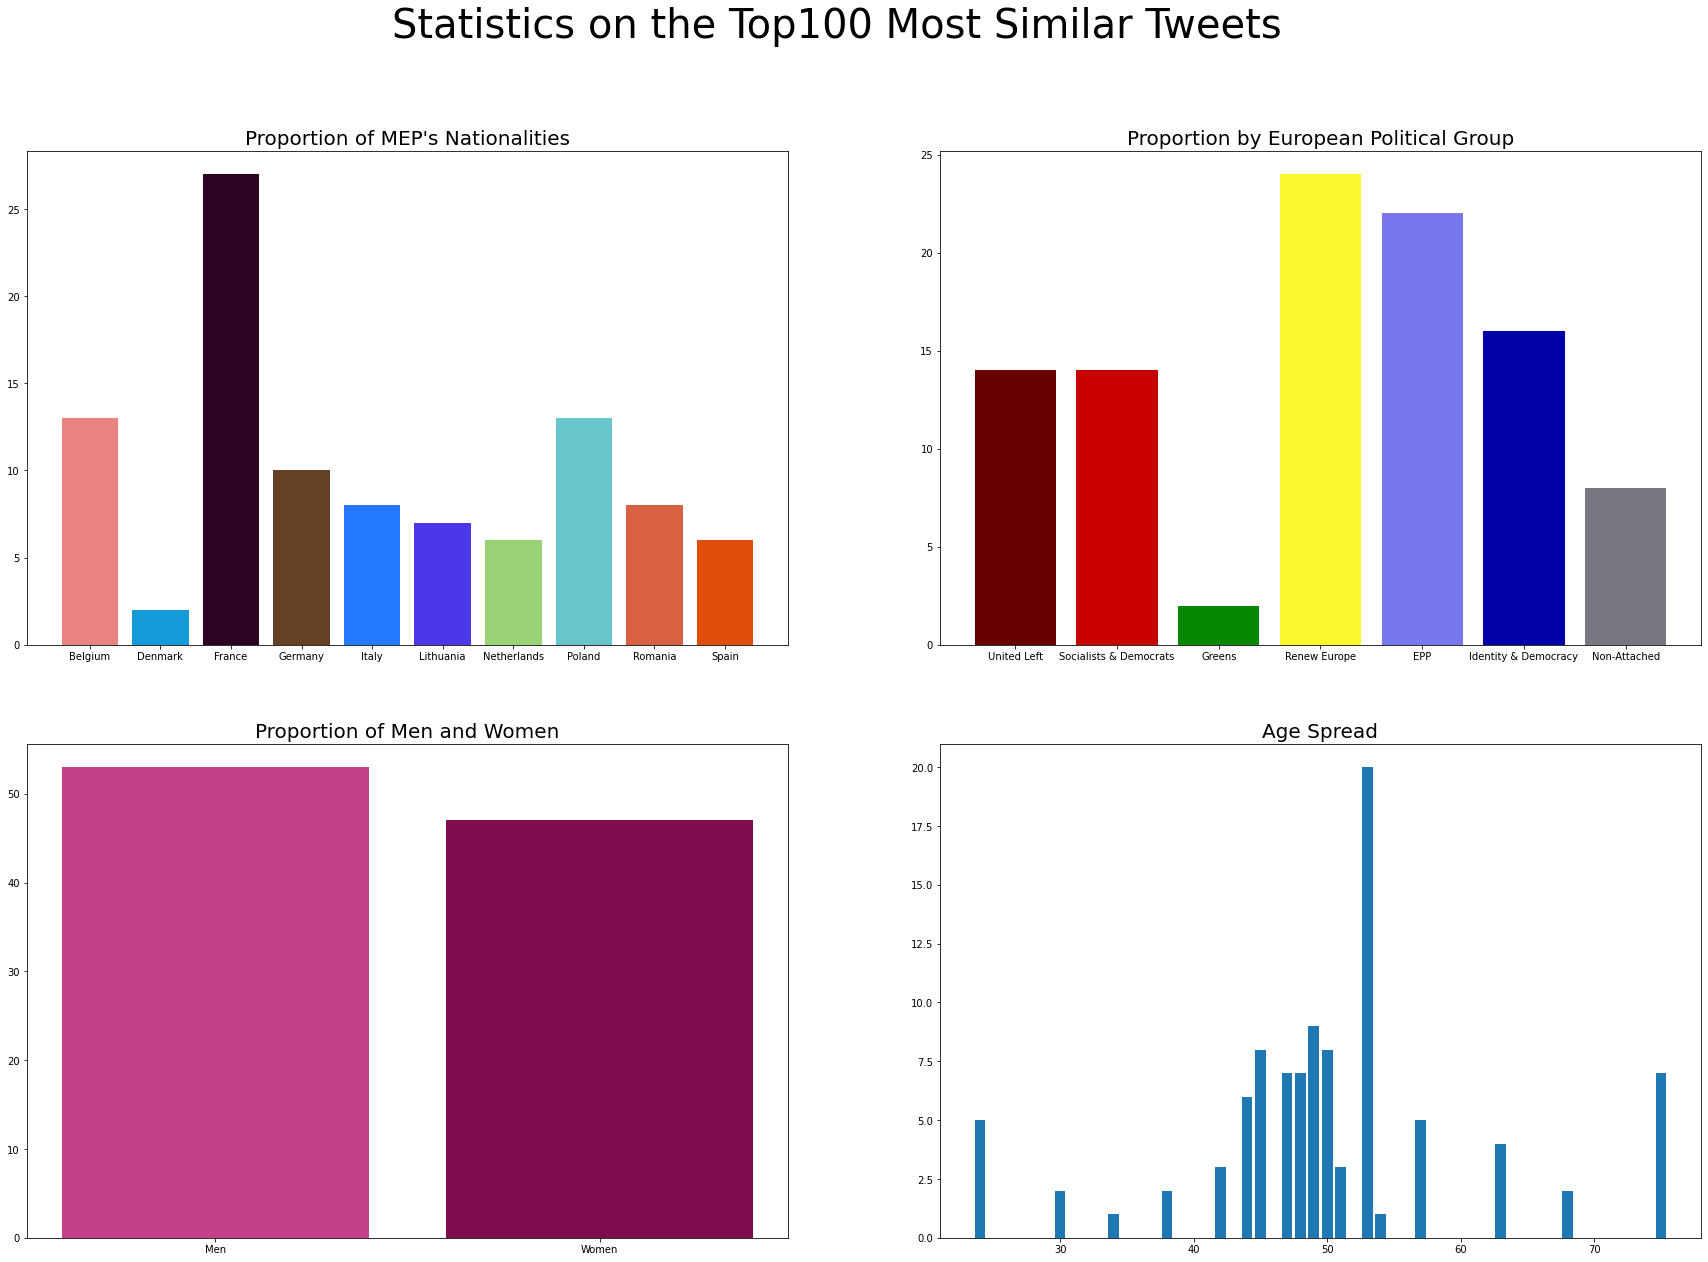

CPU times: user 1min 24s, sys: 598 ms, total: 1min 25s
Wall time: 1min 25s


In [27]:
%%time
stats(dictionary[50],100)